Louay Medhat - 20201447561

Classification of Animal Sounds Using Multi-Layer Perceptron

In [1]:
import os, time, math, random, json

import torch
import torchaudio

from torch import nn
from torch.nn import functional as Functional
from torch.utils.data import DataLoader, Dataset

import torchaudio.functional as F
import torchaudio.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from prettytable import PrettyTable

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)

In [3]:
dv = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
dv

device(type='cpu')

In [4]:
base_path = 'cats_dogs/'

In [5]:
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [6]:
train_dog_path =  os.path.join(train_path, "dog")
train_cat_path =  os.path.join(train_path, "cat")
test_dog_path =  os.path.join(test_path, "dog")
test_cat_path =  os.path.join(test_path, "cat")

In [7]:
waveform, sample_rate = torchaudio.load(
    os.path.join(train_cat_path, "cat_159.wav")
)
waveform, sample_rate

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0007,  0.0006, -0.0020]]), 16000)

In [8]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [9]:
play_audio(waveform, sample_rate)

In [10]:
classes = ["cat", "dog"]
def load_audio(path:str):
  waveform, sample_rate = torchaudio.load(path)
  return waveform, sample_rate

def load_data(path, class_name):
  data = list()
  for audio in os.listdir(path):
    waveform, sample_rate = load_audio(os.path.join(path, audio))
    data.append([waveform, sample_rate, class_name, classes.index(class_name)])
  return data

In [11]:
rain_data = []
test_data = []

train_cats = load_data(train_cat_path, "cat")
train_dogs = load_data(train_dog_path, "dog")

test_cats = load_data(test_cat_path, "cat")
test_dogs = load_data(test_dog_path, "dog")
train_data = train_cats + train_dogs
test_data = test_cats + test_dogs

random.shuffle(train_data)
random.shuffle(test_data)


assert len(train_data) == len(train_dogs) + len(train_cats)
assert len(test_data) == len(test_dogs) + len(test_cats)

In [12]:
train_data[0]

[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0370, 0.0382, 0.0440]]),
 16000,
 'cat',
 0]

Shape of waveform: torch.Size([1, 192000])
Sample rate of waveform: 16000


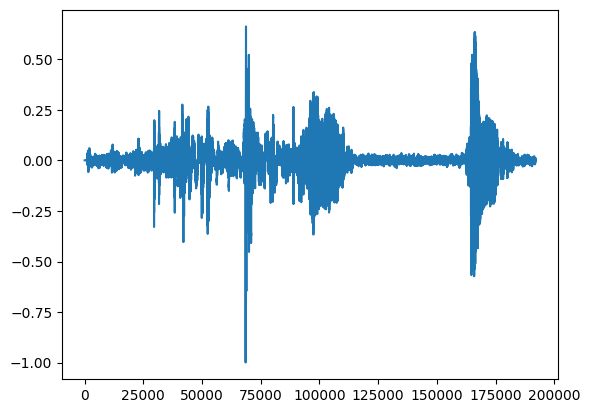

In [13]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())
plt.show()

In [14]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=new_sample_rate)
transformed = transform(waveform)

In [15]:
class CatsDogsAudio(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.len = len(data)
    self.x = [i[0].numpy() for i in self.data]
    self.y = [i[-1] for i in self.data]
    self.transform = transform
      
  def __getitem__(self, index):
    sample = self.x[index], self.y[index]
    
    if self.transform:
        sample = self.transform(sample)
    return sample
  
  def __len__(self):
    return self.len

In [16]:
class ToTensor:
  def __call__(self, samples):
    x, y = samples
    return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y, dtype='float32'))

In [17]:
train = CatsDogsAudio(data=train_data, transform=ToTensor())
test  = CatsDogsAudio(data=test_data, transform=ToTensor())

In [18]:
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  for row in data:
    table.add_row(row)
  print(table)


column_names = ["SUBSET", "EXAMPLE(s)"]
data = [
        ["training", len(train)],
        ['validation/test', len(test)],
]
tabulate(column_names, data)

+-----------------+------------+
|      SUBSET     | EXAMPLE(s) |
+-----------------+------------+
|     training    |    210     |
| validation/test |     67     |
+-----------------+------------+


In [19]:
train[0]

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0370, 0.0382, 0.0440]]), tensor(0.))

In [20]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0, 2, 1)

def collate_fn(batch):
  tensors, targets = [], []

  for waveform, label in batch:
    # apply the transformations, by downsampling the wavefor from sample_rate 16000 to 8000
    tensors += [transform(waveform)]
    targets += [label]
  tensors = pad_sequence(tensors)
  targets = torch.stack(targets)
  return tensors, targets

In [21]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [22]:
next(iter(train_loader))

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 2.0424e-03, -1.1132e-03, -7.3663e-03,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-2.3948e-01,  1.7691e-01,  5.9140e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         ...,
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-4.5244e-06, -6.1310e-05, -1.3500e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-1.0994e-02, -3.6749e-02,  7.0043e-03,  ...,  4.9534e-02,
            6.1598e-02,  1.9452e-02]]]),
 tensor([0., 1., 0., 0., 0., 0., 1., 0.]))

In [23]:
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super(M5, self).__init__()
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(n_channel)
    self.pool1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(n_channel)
    self.pool2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(2 * n_channel)
    self.pool3 = nn.MaxPool1d(4)

    self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
    self.bn4 = nn.BatchNorm1d(2 * n_channel)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(2 * n_channel, n_output)


  def forward(self, x):
    x = self.conv1(x)
    x = Functional.relu(self.bn1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = Functional.relu(self.bn2(x))
    x = self.pool2(x)
    x = self.conv3(x)
    x = Functional.relu(self.bn3(x))
    x = self.pool3(x)
    x = self.conv4(x)
    x = Functional.relu(self.bn4(x))
    x = self.pool4(x)
    x = Functional.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    x = self.fc1(x)
    return x 

In [24]:
model = M5(n_input=transformed.shape[0], n_output=1).to(dv)
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 24,705
Total tainable parameters: 24,705


In [26]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(dv)

In [27]:
def binary_accuracy(y_preds, y_true):
  #round predictions to the closest integer
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float() #convert into float for division 
  acc = correct.sum() / len(correct)
  return acc

In [28]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for X, y in iterator:
    X = X.to(dv)
    y = y.to(dv)
    optimizer.zero_grad()
    predictions = model(X).squeeze()
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for X, y in iterator:
      X = X.to(dv)
      y = y.to(dv)
      predictions = model(X).squeeze()
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [31]:
def visualize_training(start, end, train_loss, train_accuracy, val_loss, val_accuracy, title):
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_accuracy:.3f}', f"{hms_string(end - start)}" ],
       ["Validation", f'{val_loss:.3f}', f'{val_accuracy:.3f}', "" ],       
  ]
  table = PrettyTable(["CATEGORY", "LOSS", "ACCURACY", "ETA"])
  table.align["CATEGORY"] = 'l'
  table.align["LOSS"] = 'r'
  table.align["ACCURACY"] = 'r'
  table.align["ETA"] = 'r'
  table.title = title
  for row in data:
    table.add_row(row)
  print(table)

In [32]:
N_EPOCHS = 15
MODEL_NAME = "cats-dogs-sound_22.pt"
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(model, 
                                train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, 
                                    test_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  visualize_training(start, end, train_loss, train_acc, valid_loss, valid_acc, title)

+--------------------------------------------+
|     EPOCH: 01/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.566 |    0.792 | 0:00:01.26 |
| Validation | 0.615 |    0.764 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.435 |    0.866 | 0:00:00.96 |
| Validation | 0.389 |    0.917 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   

In [33]:
def pad_sequence(batch):
  batch = torch.nn.utils.rnn.pad_sequence([batch], batch_first=True, padding_value=0.)
  return batch

def preprocess(waveform):
  waveform = pad_sequence(waveform)
  return transform(waveform)

In [34]:
classes = ["cat", "dog"]

def predict_label(model, waveform):
  processed = preprocess(waveform).to(dv)
  model.eval()
  with torch.no_grad():
    prediction = torch.sigmoid(model(processed).squeeze())
    probability = float(prediction.item()) if prediction.item() > .5 else 1 - prediction.item()
    label = 1 if prediction.item() >= 0.5 else 0
    pred =  {
        'label': label,
        'class': classes[label],
        'probability':round(probability, 2),
    }
    return pred

predict_label(model, train_data[0][0])

{'label': 0, 'class': 'cat', 'probability': 0.99}

In [35]:
play_audio(train_data[0][0], sample_rate)

In [36]:
predict_label(model, train_data[1][0])

{'label': 1, 'class': 'dog', 'probability': 1.0}

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [38]:
def plot_confusion_matrix(labels:list, pred_labels:list, classes:list=[]):
  fig = plt.figure(figsize = (7, 7))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)

  if len(classes) == 0:
    classes = labels.numpy()

  cm = ConfusionMatrixDisplay(cm, display_labels= classes)
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20, color="black", fontsize=15)
  plt.yticks(rotation = 20, color="black", fontsize=15)

In [39]:
y_true =[]
y_preds = []

for X, _, __, y in test_data:
  X = preprocess(X)
  X = X.to(dv)
  y_true.append(y)

  prediction = torch.sigmoid(model(X).squeeze())
  label = 1 if prediction.item() >= 0.5 else 0
  y_preds.append(label)

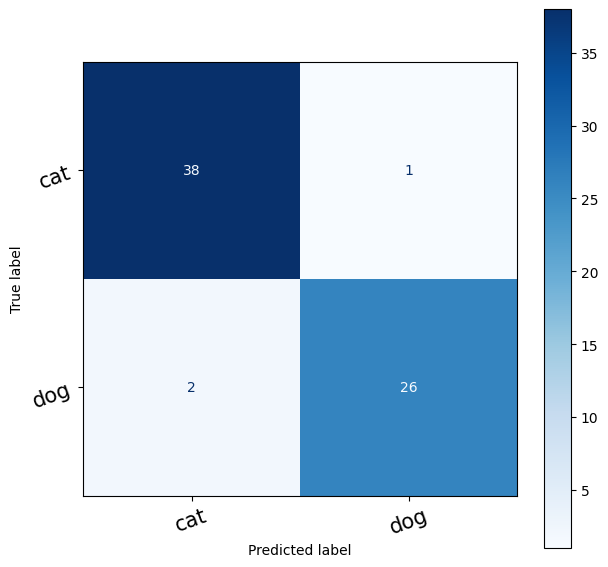

In [40]:
plot_confusion_matrix(y_true, y_preds, classes)

In [41]:
from sklearn.metrics import classification_report

In [42]:
cr = classification_report(y_true, y_preds, output_dict=False, labels=y_true, target_names =[classes[i] for i in y_true])
print(cr)

              precision    recall  f1-score   support

         dog       0.96      0.93      0.95        28
         cat       0.95      0.97      0.96        39
         dog       0.96      0.93      0.95        28
         dog       0.96      0.93      0.95        28
         cat       0.95      0.97      0.96        39
         dog       0.96      0.93      0.95        28
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         dog       0.96      0.93      0.95        28
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         dog       0.96      0.93      0.95        28
         cat       0.95      0.97      0.96        39
         cat       0.95      0.97      0.96        39
         dog       0.96    